In [36]:
import torch
from torchvision import datasets
import torchvision.transforms as transform
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from torchvision.datasets import ImageFolder

In [37]:
model = YOLO("/home/oz31/code/personal/python/training-skripsi/training-cnn/yolo/yolo11_cls_exp/weights/best.pt")  # Nano classification model, pre-trained on ImageNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [38]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (should match those used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as per your model's requirement
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet means
                         std=[0.229, 0.224, 0.225])   # Standard ImageNet stds
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root='../../dataset/Test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [39]:
test_folder = '/home/oz31/code/personal/python/training-skripsi/dataset/Test'

In [54]:
import os
from sklearn.metrics import classification_report
from collections import Counter

# Initialize variables
all_preds = []
all_labels = []

# Iterate over each subfolder (class) in the Test folder
for class_name in os.listdir(test_folder):
    class_folder = os.path.join(test_folder, class_name)
    if os.path.isdir(class_folder):
        # Run predictions on the images in the class folder
        results = model.predict(source=class_folder, imgsz=224, device=0, save=True, save_txt=True)
        
        # Extract predictions and true labels
        for result in results:
            pred_class_idx = torch.argmax(result.probs.data)
            pred_class = model.names[pred_class_idx.item()]  # Get predicted class name
            true_class = class_name  # True class name is the folder name
            
            all_preds.append(pred_class)
            all_labels.append(true_class)

# Get unique class names (sorted to match classification_report)
class_names = sorted(os.listdir(test_folder))

# Generate classification report as a dictionary
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)

# Calculate per-class accuracy and overall accuracy
label_counts = Counter(all_labels)  # Count total samples per class
correct_counts = Counter()  # Count correct predictions per class
correct_total = 0  # Total correct predictions across all classes
total_samples = len(all_labels)  # Total number of samples

for true_label, pred_label in zip(all_labels, all_preds):
    if true_label == pred_label:
        correct_counts[true_label] += 1
        correct_total += 1

# Calculate overall accuracy
overall_accuracy = (correct_total / total_samples * 100) if total_samples > 0 else 0.0

# Format and print the per-class table
print(f"{'Class':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Accuracy':<10}")
print("-" * 65)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    f1_score = report[class_name]['f1-score']
    
    # Calculate per-class accuracy
    class_total_samples = label_counts[class_name]
    class_correct_samples = correct_counts.get(class_name, 0)
    class_accuracy = (class_correct_samples / class_total_samples * 100) if class_total_samples > 0 else 0.0
    
    # Print formatted row
    print(f"{class_name:<25} {precision:<10.2f} {recall:<10.2f} {f1_score:<10.2f} {class_accuracy:<10.2f}")

# Print overall accuracy
print("\n" + "-" * 65)
print(f"{'Overall Accuracy':<25} {'':<10} {'':<10} {'':<10} {overall_accuracy:<10.2f}")


image 1/109 /home/oz31/code/personal/python/training-skripsi/dataset/Test/leaf-rust/IMG_0780_JPG_jpg.rf.a23ec7542f1bf98e9eec8fe9acd2d00d.jpg: 224x224 red-spider-infested 0.97, leaf-rust 0.03, brown-blight 0.00, gray-blight 0.00, helopeltis 0.00, 3.8ms
image 2/109 /home/oz31/code/personal/python/training-skripsi/dataset/Test/leaf-rust/IMG_0785_JPG_jpg.rf.aeb073507a447ef1fdb52b5eda8e2a8d.jpg: 224x224 red-spider-infested 0.99, leaf-rust 0.01, helopeltis 0.00, brown-blight 0.00, gray-blight 0.00, 3.8ms
image 3/109 /home/oz31/code/personal/python/training-skripsi/dataset/Test/leaf-rust/IMG_0786_JPG_jpg.rf.3db29859377558161e7d1c3a2b4b7e63.jpg: 224x224 red-spider-infested 0.98, leaf-rust 0.02, gray-blight 0.00, brown-blight 0.00, white-spot 0.00, 3.3ms
image 4/109 /home/oz31/code/personal/python/training-skripsi/dataset/Test/leaf-rust/IMG_0792_JPG_jpg.rf.fc8746b1d066f5d1eaca8b1459080d68.jpg: 224x224 red-spider-infested 1.00, leaf-rust 0.00, brown-blight 0.00, gray-blight 0.00, helopeltis 0.0

/tmp/ipykernel_508380/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_508380/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_508380/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_508380/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

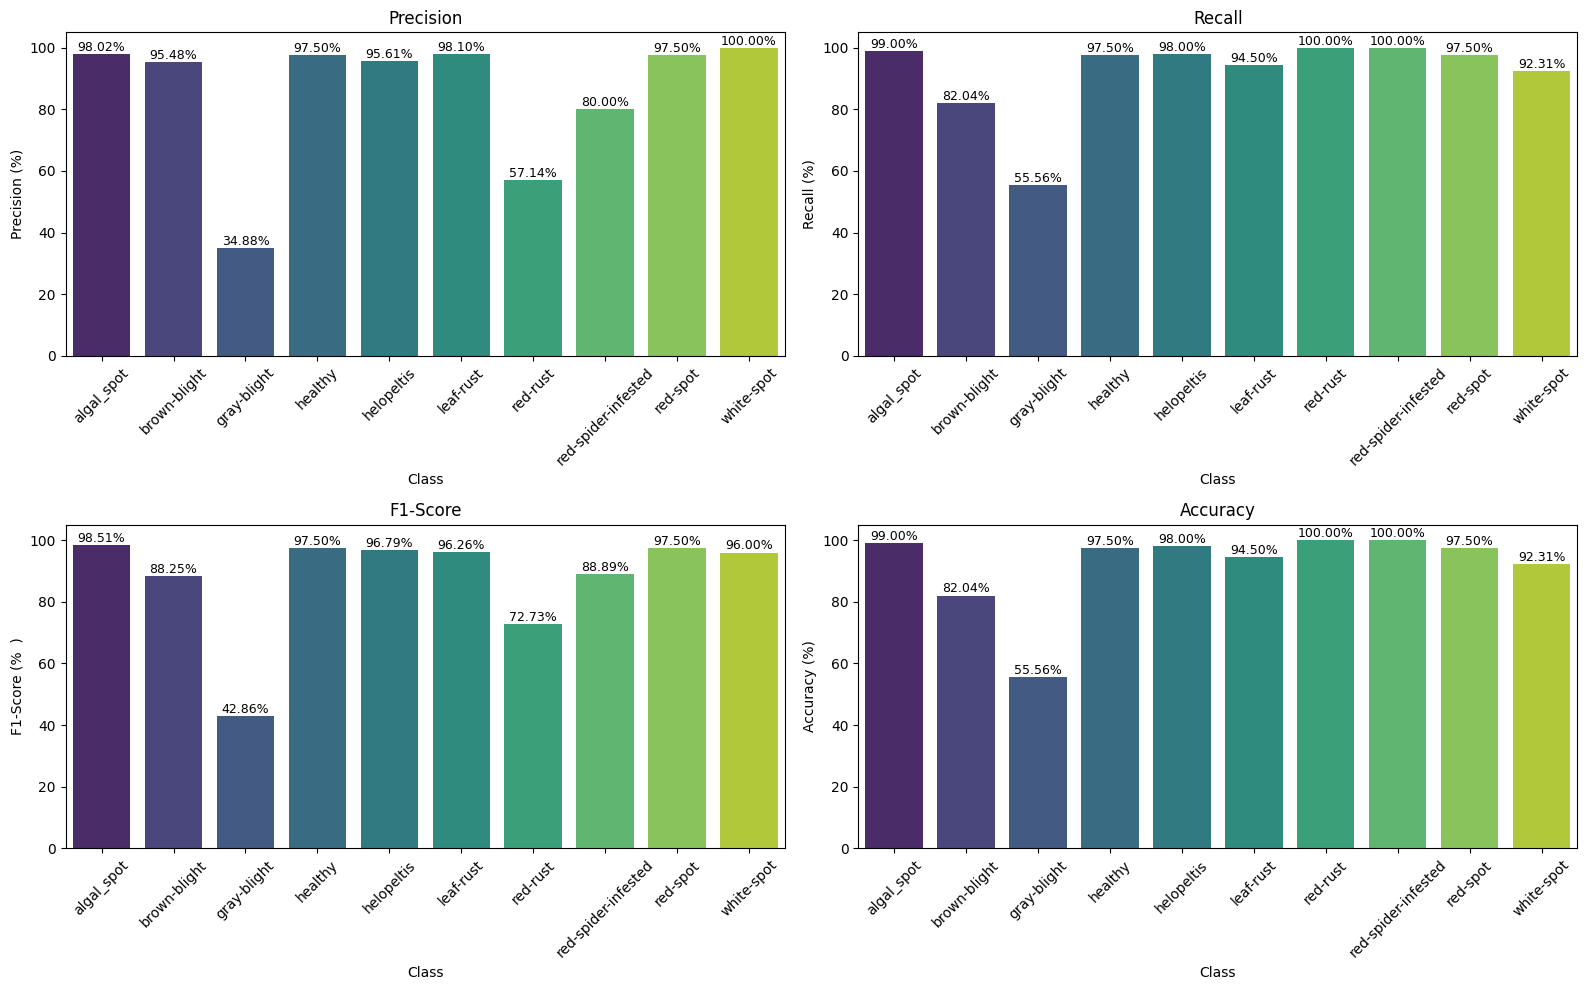

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# ambil metric masing-masing class
class_names = list(test_dataset.classes)
precisions = [report[cls]['precision'] * 100 for cls in class_names]
recalls = [report[cls]['recall'] * 100 for cls in class_names]
f1_scores = [report[cls]['f1-score'] * 100 for cls in class_names]
accuracies = [report[cls]['recall'] * 100 for cls in class_names]

# setup plot
plt.figure(figsize=(16, 10))
metrics = [precisions, recalls, f1_scores, accuracies]
titles = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
ylabels = ['Precision (%)', 'Recall (%)', 'F1-Score (%  )', 'Accuracy (%)']

for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
    plt.title(titles[i])
    plt.xlabel('Class')
    plt.ylabel(ylabels[i])    
    plt.ylim(0, 105)
    plt.xticks(rotation=45)
    
    for idx, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1,
                f'{height:.2f}%', ha="center", fontsize=9)

plt.tight_layout()
plt.show()